The goal of this notebook is to implement the Bayesian LASSO method for a 1D problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import recipinvgauss
import scipy.sparse as sps
from scipy.sparse.linalg import cg

from fastprogress import progress_bar

from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

from runningstatistics import StatsTracker
import jlinops
import sampi

# Make toy problem

In [2]:
ground_truth = jlinops.piecewise_constant_1d_test_problem()
n = len(ground_truth)
np.random.seed(0)
noise_stdev = 0.05
noise_var = noise_stdev**2
blur_sigma = 4.0
#blur_op = jlinops.Gaussian1DBlurOperator(n, blur_sigma=blur_sigma, mode="constant")
blur_op = jlinops.IdentityOperator((n,n))
noisy_signal = blur_op.matvec(ground_truth) + noise_stdev*np.random.normal(size=n)
grid = np.arange(n)

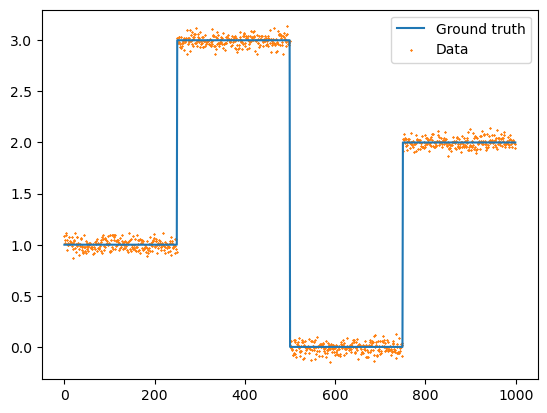

In [3]:
plt.plot(grid, ground_truth, label="Ground truth", color="C0")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

In [4]:
# Define forward operator and regularization matrix
F = blur_op
R, _ = jlinops.first_order_derivative_1d(n, boundary="none")
R = jlinops.MatrixLinearOperator(R)

# Set regularization lambda
reg_lambda = 3

# MAP estimate of the L1 problem

By L1 problem, I mean solving
$$
\operatorname{argmin}_x \left\{ \frac{1}{2 \sigma^2} \| x - y \|_2^2 + \lambda \| R x \|_1 \right\} = \operatorname{argmin}_x \left\{ \frac{1}{2} \| x - y \|_2^2 + (\lambda \sigma^2) \| R x \|_1 \right\}.
$$

In [5]:
# We can solve this problem using FISTA
f = sampi.GaussianDataLikelihood(F, noisy_signal, v=noise_var)
g = sampi.TV1DPenalty(n, boundary="none", reg_lam=reg_lambda)
obj = sampi.CompositeModelObjectiveFunction(f, g)
solver = sampi.MFISTASolver(obj)
mfista_solver_data = solver.solve(iterations=100, L=None)

In [6]:
R.A.toarray()

array([[ 1., -1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1., -1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1., -1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1., -1.]])

[]

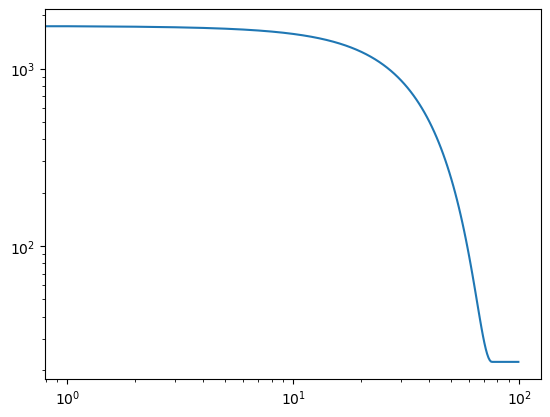

In [7]:
plt.loglog(mfista_solver_data["obj_vals"])
plt.plot()

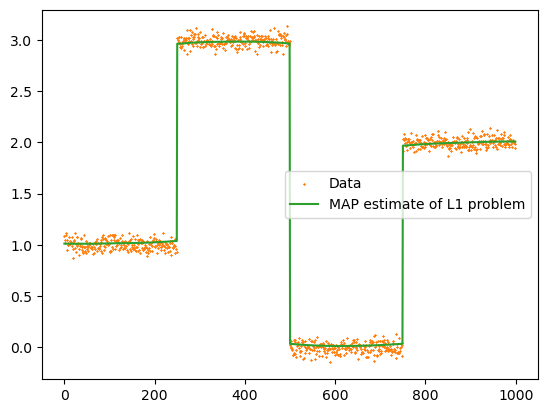

In [8]:
map_result = mfista_solver_data["result"]
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.plot(grid, map_result, label="MAP estimate of L1 problem", color="C2")
plt.legend()
plt.show()

# Sample the posterior of the Gaussian model

$$
-\log \pi(x)  = \left\{ \frac{1}{2 \sigma^2} \| x - y \|_2^2 + \frac{\lambda}{2} \| R x \|_2^2 \right\} + C
$$

In [206]:
# def gauss_posterior_summary(F, R, y, noise_var=1.0, reg_lambda=1e1):
#     """Computes posterior mean and stdev.
#     """
#     Q = sps.csc_matrix((1/noise_var)*(F.A.T @ F.A) + reg_lambda*(R.A.T @ R.A))
#     Q = jlinops.MatrixLinearOperator(Q)
#     Linv = jlinops.BandedCholeskyFactorInvOperator(Q)
#     mean = Linv.T @ (Linv @  ((1/noise_var)*F.T @ y) )

#     # Get diagonal entries of Qinv
#     Qinv = Linv.T @ Linv
#     var = jlinops.black_box_diagonal(Qinv)
#     stdev = np.sqrt(var)
#     return mean, stdev

In [108]:

# gauss_mu, gauss_sigmas = gauss_posterior_summary(F, R, noisy_signal, noise_var=noise_var, reg_lambda=1e4)

In [109]:
# #plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
# plt.plot(grid, gauss_mu, label="Mean vector", color="C2")
# plt.fill_between(grid, gauss_mu - 3*gauss_sigmas, gauss_mu + 3*gauss_sigmas, color="C4", alpha=0.5, label="3 sigma band")
# plt.legend()
# plt.show()

# Inverse Gaussian helper function

In [163]:
# def sample_inv_gaussian(mu, lam):
#     """Draws samples of the inverse Gaussian distribution with parameters \mu and \lambda, where the density is
#     p(x) \propto x^{-3/2} \exp\{ - \lambda*(x-\mu)^2 / (2 \mu^2 x)  \}.
#     """
#     mu = np.atleast_1d(mu)
#     lam = np.atleast_1d(lam)

#     if not len(mu) == len(lam):
#         return None
#     else:
#         n = len(mu)


#         # Draw nu
#         nu = np.random.normal(size=n)

#         # Square it
#         y = nu**2

#         # Compute x
#         x = mu + (((mu**2)*y)/(2*lam)) - (mu/(2*lam))*np.sqrt( 4*mu*lam*y + ((mu*y)**2)  )

#         # Generate z
#         z = np.random.uniform(size=n)

#         # Logic for last step
#         true_cond = mu/(mu+x)
#         true_idx = np.where(z <= true_cond)
#         false_idx = np.where(z > true_cond)
#         true_arr = x[true_idx]
#         false_arr = (mu[false_idx]**2)/x[false_idx]
#         result = np.zeros(n)
#         result[true_idx] = true_arr.copy()
#         result[false_idx] = false_arr.copy()

#         return result

In [164]:
# sample_inv_gaussian( np.random.uniform(size=10), np.random.uniform(size=10) )

# Bayesian LASSO

In [9]:
class BayesianLASSOGibbsSampler:
    """Implements the Bayesian LASSO hierarchical sampler for the L1 problem.
    """

    def __init__(self, F, R, y, noise_var=1.0, reg_lambda_params={}):

        self.F = F
        self.R = R
        self.y = y
        self.noise_var = noise_var
        self.noise_stdev = np.sqrt(noise_var)
        self.reg_lambda_params = reg_lambda_params
        self.delta = reg_lambda_params["delta"]
        self.r = reg_lambda_params["r"]
        
        self.m = F.shape[0]
        self.k = R.shape[0]
        self.n = R.shape[1]

        self.last_x_solve = None


    def sample(self, n_samples, x0=None, n_burn=0, theta_tol=1e-2, lam0=None, x_params={}):
        """Runs the Gibbs sampler.
        """

        # Initialize
        if x0 is None:
            x = np.zeros(self.F.shape[1])
        else:
            x = x0

        if lam0 is None:
            lam = 1.0
        else:
            lam = lam0

        # Create trackers
        x_tracker = StatsTracker(self.F.shape[1])
        theta_tracker = StatsTracker(self.R.shape[0])

        # For taking care of lambda udpates
        # lam_update_fn = lambda theta_ss_est: np.sqrt( 2*self.R.shape[0]/theta_ss_est )
        # theta_sum_tracker = StatsTracker((1,))
        # lam_hist = [lam]
        # theta_sums_all = []
        #reg_eta_hist = [reg_]
        lam_hist = [lam]
      

        # For tracking when gaussian draws are accepted
        x_draws_accepted = 0
        x_samples = []
        theta_samples = []

        # Run the sampler
        for j in progress_bar(range(n_samples+n_burn)):

            # Update theta
            theta = self.sample_theta(x, lam, tol=theta_tol)
            theta_samples.append(theta)

            # Update x
            x, accepted = self.sample_x(theta, x, **x_params)
            if j >= n_burn:
                if accepted:
                    x_draws_accepted += 1
            x_samples.append(x)

            # Get new eta_sq
            lam = self.sample_lam(theta)
            lam_hist.append(lam)
            #reg_etasq = self.sample_reg_etasq(theta)
            #reg_eta_hist.append(reg_etasq)

            # Push to tracker
            if j >= n_burn:
                x_tracker.push(x)
                theta_tracker.push(theta)

        
        results = {
            "x_tracker": x_tracker,
            "theta_tracker": theta_tracker,
            "x_samples": x_samples,
            "theta_samples": theta_samples,
            "lam_hist": np.asarray(lam_hist),
            #"etasq_hist": np.asarray(reg_eta_hist),
            # "lam_hist": 1.0/np.asarray(reg_eta_hist),
            "x_draws_acceptance_rate": x_draws_accepted/n_samples,
        }

        return results


    def sample_x(self, theta, x_old, cg_maxits=None, cg_tol=1e-3, ar_step=True):
        """Given local variances theta, draws a sample for x.
        """


        # Update using RJPO method
        if cg_maxits is None:
            cg_maxits = self.n
        
        # Sample eta
        Ls = [ (1.0/self.noise_stdev)*self.F.T, self.R.T @ jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta))) ]
        Qmu = (1.0/self.noise_var)*(self.F.T @ self.y)
        eta = self.sample_eta(Qmu, Ls)

        # Solve system approximately
        Q = (1.0/self.noise_var)*(self.F.T @ self.F) + (self.R.T @ ( jlinops.MatrixLinearOperator(sps.diags(1.0/theta)) @ self.R ) )
        if self.last_x_solve is None:
            warmstart = None
        else:
            warmstart = - self.last_x_solve
        x_approx, _ = cg(Q, eta, x0=warmstart, maxiter=cg_maxits, tol=cg_tol)
        
        if not ar_step:
            return x_approx, True

        # x_approx = x_approx_solve["x"]
        # tot_cg_its += x_approx_solve["iterations"]

        # Compute residual
        # print(eta)
        # print(Q @ x_approx)
        #print(x_approx)
        residual = eta - (Q @ x_approx)

        # Accept or reject
        log_uniform = np.log(np.random.uniform())
        log_accept = np.amin([0.0, -residual.T @ (x_old - x_approx)])

        if log_uniform < log_accept:
            x = x_approx
            accepted = True
        else:
            x = x_old
            accepted = False

        self.last_x_solve = x

        return x, accepted

    

    def sample_theta(self, x, lam, tol=1e-7):
        """Given x, draws a sample for the thetas.
        """

        # Get Rx
        Rx = self.R @ x

        # Make output array
        sample = np.zeros(self.R.shape[0])


        # Need to check where Rx is close to zero, so we can sample from exponential there instead
        idx_too_small = np.where(np.abs(Rx) < tol)
        idx_fine = np.where(np.abs(Rx) >= tol)

        # Break into two parts
        Rx_too_small = Rx[idx_too_small]
        Rx_fine = Rx[idx_fine]

        # For the components near zero, sample from the Gamma
        #theta_from_too_small = np.random.exponential(scale=1.0/lam, size=len(Rx_too_small))
        theta_from_too_small = np.random.gamma(0.5, scale=2.0*lam, size=len(Rx_too_small))
        #print(theta_from_too_small)

        # For the components not near zero, sample from the inverse Gaussian
        mu = np.sqrt(lam)/np.abs(Rx_fine)
        ig_lam = lam
        #theta_from_fine = sample_inv_gaussian(mu, lam)
        theta_from_fine = 1.0/np.random.wald(mu, scale=ig_lam, size=len(mu))
        #print(theta_from_fine)
        # theta_from_fine = recipinvgauss.rvs(mu=np.abs(Rx_fine)/np.sqrt(etasq), scale=1.0/(lam**2))

        # Put all into one array
        sample[idx_too_small] = theta_from_too_small
        sample[idx_fine] = theta_from_fine

        #sample += 1e-10
        assert np.all(sample > 0), "some thetas are no positive!"
        

        return sample


    def sample_eta(self, Qmu, Ls):
        """Draws a sample from $\mathcal{N}(Q \mu, Q)$. Here $Q$ is assumed to be of the form $Q = \sum_{i=1}^p L_i^T L_i$,
        where the $L_i$ are collected in Ls."""
         
        # Draw sample with correct covariance
        sample = np.zeros(self.n)
        for L in Ls:
            sample += L.matvec( np.random.normal(size=L.shape[1]) )

        # Add mean
        sample += Qmu
        
        return sample
    

    def sample_lam(self, theta):
        """Samples from the conditional for the regularization parameter.
        """
        
        shape_param = self.k + self.r
        rate_param = self.delta + 0.5*theta.sum()

        lam = np.random.gamma(shape_param, scale=1.0/rate_param)

        return lam


    # def sample_reg_etasq(self, theta):
    #     """Samples from the conditional for the regularization parameter.
    #     """
        
    #     shape_param = self.k + self.r
    #     rate_param = self.delta + 0.5*theta.sum()

    #     recip_reg_etasq = np.random.gamma(shape_param, scale=1.0/rate_param)
    #     reg_etasq = 1.0/recip_reg_etasq

    #     return reg_etasq

In [18]:
reg_lambda_params = {
    "r": 1.0,
    "delta": 1e2,
}

In [19]:
lasso_sampler = BayesianLASSOGibbsSampler(F, R, noisy_signal, noise_var=noise_var, reg_lambda_params=reg_lambda_params)

In [20]:
sampling_result = lasso_sampler.sample(n_samples=500, n_burn=200, lam0=1e2, x_params={"cg_maxits":1000, "cg_tol":1e-3, "ar_step":False})

In [21]:
sampling_result["x_draws_acceptance_rate"]

1.0

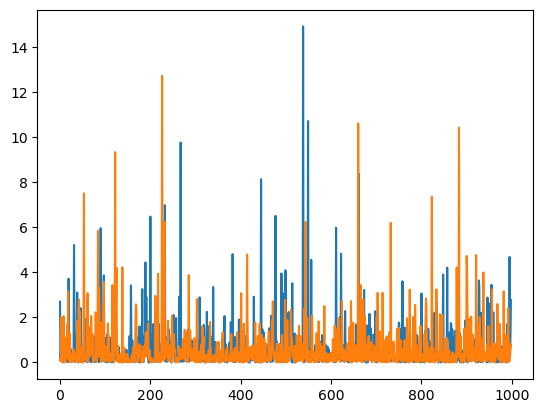

In [22]:
plt.plot(sampling_result["theta_samples"][-1])
plt.plot(sampling_result["theta_samples"][-2])
plt.show()

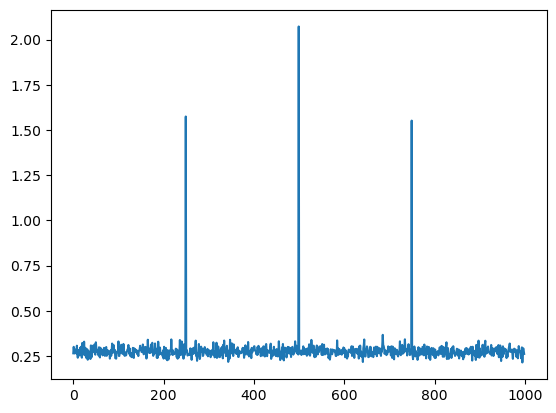

In [23]:
#plt.plot( np.quantile(np.vstack(sampling_result["theta_samples"]), q=0.05, axis=0) )

plt.plot( np.quantile(np.vstack(sampling_result["theta_samples"]), q=0.5, axis=0) )
#plt.plot(np.mean(np.vstack(sampling_result["theta_samples"]), axis=0))
# plt.plot(sampling_result["x_tracker"].mean())

#plt.plot( np.quantile(np.vstack(sampling_result["theta_samples"]), q=0.95, axis=0) )
plt.show()

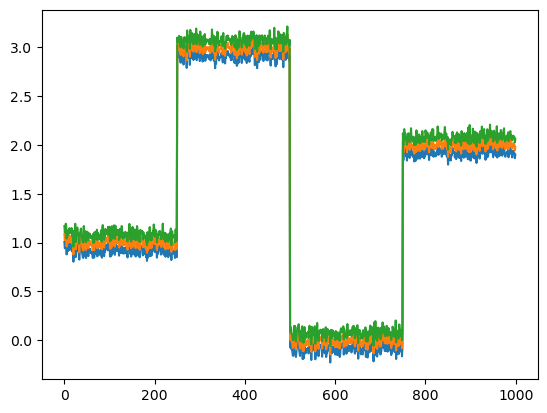

In [24]:
plt.plot( np.quantile(np.vstack(sampling_result["x_samples"]), q=0.05, axis=0) )
#plt.plot(sampling_result["x_tracker"].mean())
plt.plot( np.quantile(np.vstack(sampling_result["x_samples"]), q=0.5, axis=0) )
plt.plot( np.quantile(np.vstack(sampling_result["x_samples"]), q=0.95, axis=0) )
plt.show()

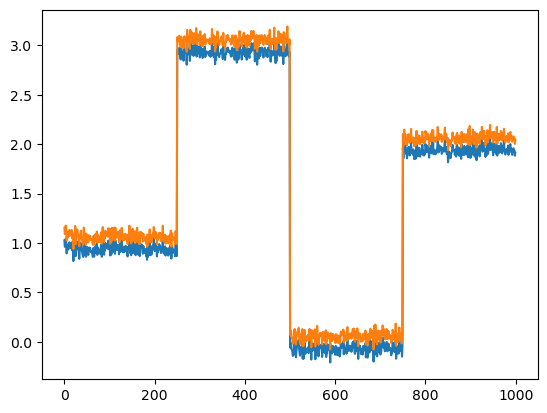

In [25]:
plt.plot( np.quantile(np.vstack(sampling_result["x_samples"]), q=0.1, axis=0) )
#plt.plot(sampling_result["x_tracker"].mean())

plt.plot( np.quantile(np.vstack(sampling_result["x_samples"]), q=0.9, axis=0) )
plt.show()

In [251]:
sampling_result["lam_hist"]

array([1.00000000e+02, 2.01360544e-02, 4.28183412e-02, 9.10360012e-02,
       1.99858903e-01, 4.20446590e-01, 8.99131509e-01, 1.91204585e+00,
       2.65771473e+00, 3.07490560e+00, 3.37680336e+00, 2.86399903e+00,
       3.05064360e+00, 3.75776918e+00, 3.18983451e+00, 3.33700332e+00,
       3.49603247e+00, 3.66664301e+00, 3.31195175e+00, 2.93380168e+00,
       3.18039902e+00, 3.19985833e+00, 2.95110578e+00, 2.88538564e+00,
       3.65838437e+00, 3.12521498e+00, 2.97335098e+00, 3.16892173e+00,
       3.79910011e+00, 3.25784105e+00, 3.39506726e+00, 3.20310538e+00,
       3.42887679e+00, 3.14079075e+00, 3.03363209e+00, 2.98325142e+00,
       3.15955850e+00, 3.09259465e+00, 3.09263324e+00, 3.23955152e+00,
       2.80386053e+00, 3.48242366e+00, 3.06528342e+00, 2.64714312e+00,
       3.36393909e+00, 3.25656819e+00, 3.38479740e+00, 3.39009323e+00,
       3.59927071e+00, 2.84794080e+00, 3.29719797e+00, 2.84219274e+00,
       3.10541928e+00, 2.92458242e+00, 3.23907712e+00, 3.47243287e+00,
      

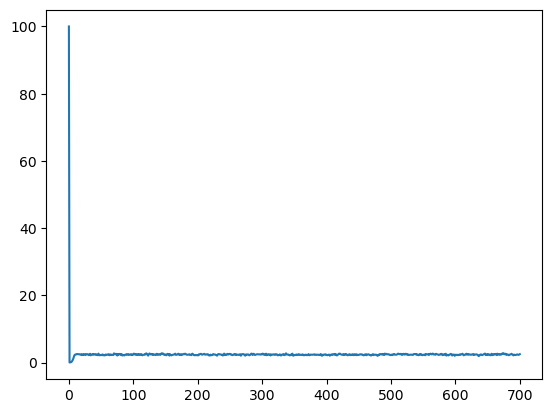

In [26]:
plt.plot(sampling_result["lam_hist"])
plt.show()

In [28]:
sampling_result["lam_hist"]

array([1.00000000e+02, 2.01464065e-02, 4.36693625e-02, 9.06612210e-02,
       1.98425736e-01, 4.31347178e-01, 7.87801692e-01, 1.25217632e+00,
       1.90337350e+00, 2.26880440e+00, 2.38578367e+00, 2.38206815e+00,
       2.51237665e+00, 2.53142500e+00, 2.48793197e+00, 2.46153711e+00,
       2.50470294e+00, 2.39999725e+00, 2.38514668e+00, 2.48436521e+00,
       2.21229835e+00, 2.41127578e+00, 2.24301681e+00, 2.51085523e+00,
       2.39209111e+00, 2.45858286e+00, 2.23812847e+00, 2.47476440e+00,
       2.49570264e+00, 2.47167205e+00, 2.30342723e+00, 2.21318410e+00,
       2.50440150e+00, 2.59362894e+00, 2.15273385e+00, 2.33628932e+00,
       2.38304599e+00, 2.53045691e+00, 2.32243204e+00, 2.49980223e+00,
       2.42845603e+00, 2.47762152e+00, 2.28340959e+00, 2.41058946e+00,
       2.30554627e+00, 2.18092418e+00, 2.65366629e+00, 2.20557869e+00,
       2.16233573e+00, 2.25128821e+00, 2.22463591e+00, 2.21399415e+00,
       2.42217244e+00, 2.14987960e+00, 2.28946461e+00, 2.15092893e+00,
      

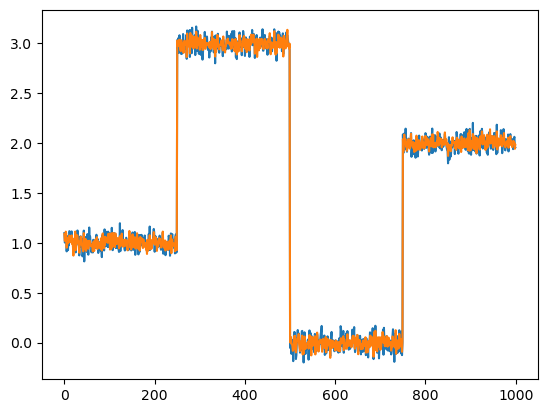

In [29]:
plt.plot(sampling_result["x_samples"][2], label="A sample")
plt.plot(noisy_signal, label="Data")
plt.show()

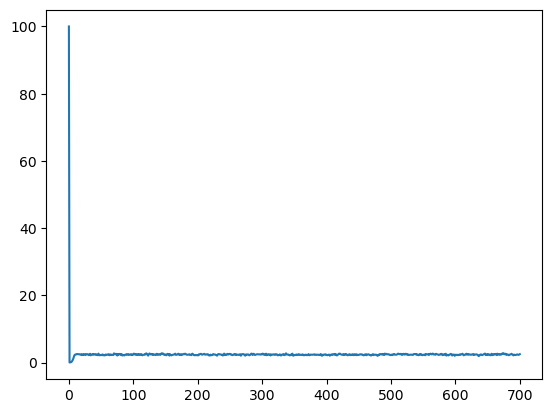

In [30]:
plt.plot(sampling_result["lam_hist"])
plt.show()

In [31]:
sampling_result["x_draws_acceptance_rate"]

1.0

In [32]:
sampling_result["lam_hist"][-1]

2.48813837271474

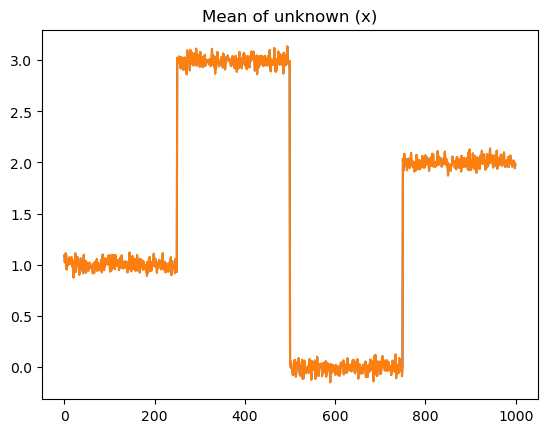

In [33]:
plt.plot(sampling_result["x_tracker"].mean())
plt.plot(noisy_signal)
plt.title("Mean of unknown (x)")
plt.show()

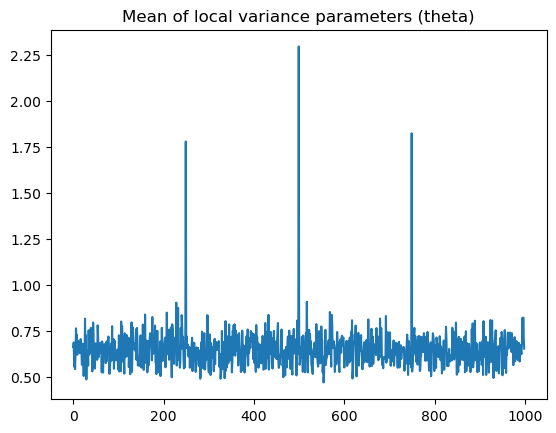

In [34]:
plt.plot(sampling_result["theta_tracker"].mean())
plt.title("Mean of local variance parameters (theta)")
plt.show()

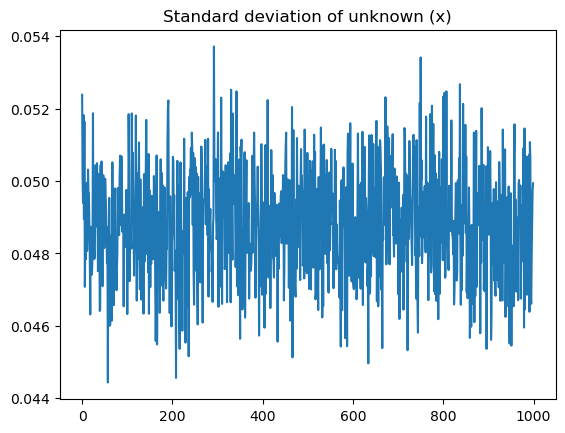

In [39]:
plt.plot(sampling_result["x_tracker"].stdev())
plt.title("Standard deviation of unknown (x)")
plt.show()

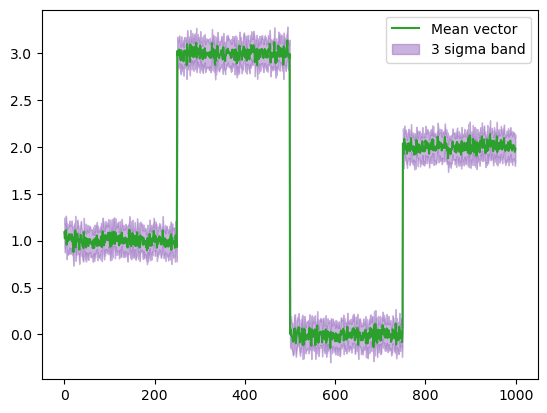

In [40]:
#plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
mu, stdev = sampling_result["x_tracker"].mean(), sampling_result["x_tracker"].stdev()
plt.plot(grid, mu, label="Mean vector", color="C2")
plt.fill_between(grid, mu - 3*stdev, mu + 3*stdev, color="C4", alpha=0.5, label="3 sigma band")
plt.legend()
plt.show()

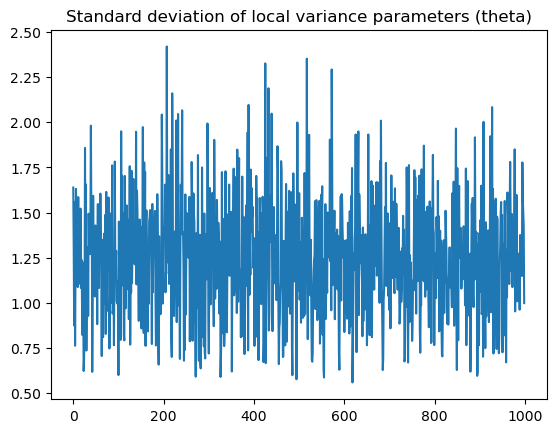

In [37]:
plt.plot(sampling_result["theta_tracker"].stdev())
plt.title("Standard deviation of local variance parameters (theta)")
plt.show()

# Comparison with other methods

In [38]:
# Do MAP again
f = sampi.GaussianDataLikelihood(F, noisy_signal, v=noise_var)
g = sampi.TV1DPenalty(n, boundary="none", reg_lam=sampling_result["lam_hist"][-1])
obj = sampi.CompositeModelObjectiveFunction(f, g)
solver = sampi.MFISTASolver(obj)
mfista_solver_data = solver.solve(iterations=5000, L=None)

In [254]:
f.L

419.99999999999994

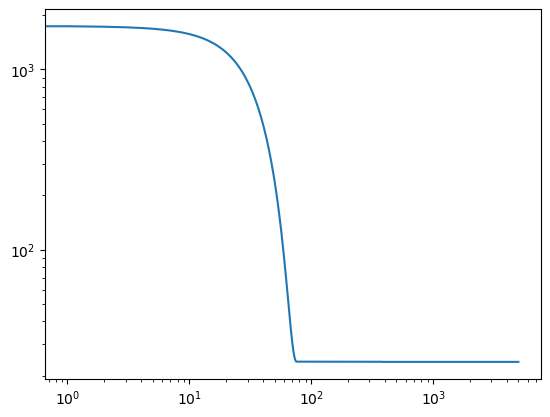

In [255]:
plt.loglog(mfista_solver_data["obj_vals"])
plt.show()

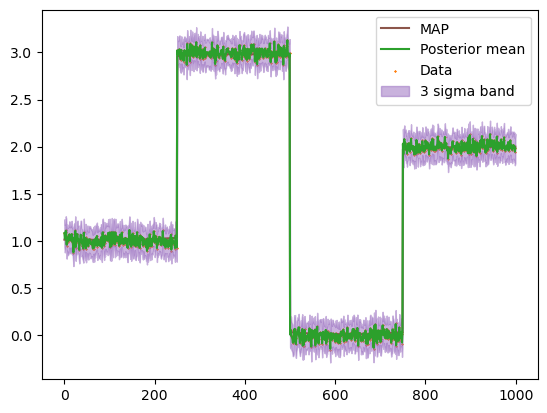

In [256]:
# Get MAP point for the lambda chosen during sampling
map_est = mfista_solver_data["result"]
#plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)

mu, stdev = sampling_result["x_tracker"].mean(), sampling_result["x_tracker"].stdev()

plt.plot(grid, map_est, label="MAP", color="C5")
plt.plot(grid, mu, label="Posterior mean", color="C2")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.fill_between(grid, mu - 3*stdev, mu + 3*stdev, color="C4", alpha=0.5, label="3 sigma band")
plt.legend()
plt.show()


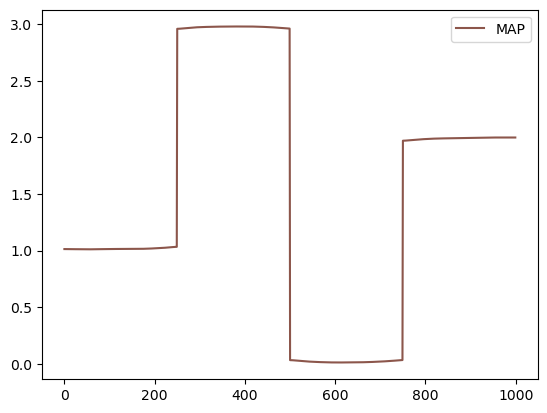

In [258]:
plt.plot(grid, map_est, label="MAP", color="C5")
plt.legend()
plt.show()